In [1]:
"""
Report downstream performance scores for a pretrained model.
"""
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

os.environ['OPENBLAS_NUM_THREADS'] = '38' #@@@@ to help with the num_workers issue
os.environ['OMP_NUM_THREADS'] = '1'  #10

import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

import transformers

import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
from ddputils import is_main_process, save_on_master, setup_for_distributed

In [2]:
import cv2
from itertools import chain

In [3]:
#------------------------------------
# Get Model
def get_config(image_size, args, num_labels=2):
    arch_kw = args.architecture
    
    if arch_kw=='base': #default
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=args.num_frames, tubelet_size=args.tubelet_size, 
                                             hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
                                             intermediate_size=3072, num_labels=num_labels)
    elif arch_kw=='small2':
        hidden_size = 768
        intermediate_size = 4*768
        num_attention_heads = 6
        num_hidden_layers = 6
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=args.num_frames, tubelet_size=args.tubelet_size, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, 
                                             num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
    
    elif arch_kw=='small1':
        hidden_size = 384
        intermediate_size = 4*384
        num_attention_heads = 6
        num_hidden_layers = 12
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=args.num_frames, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
        
    elif arch_kw=='small3':
        hidden_size = 384
        intermediate_size = 4*384
        num_attention_heads = 6
        num_hidden_layers = 6
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size)
        
    else:
        raise ValueError
    return config


def init_model_from_checkpoint(model, checkpoint_path):
    # caution: model class
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def adapt_videomae(source_model, target_model):
    # load the embeddings
    target_model.videomae.embeddings.load_state_dict(
        source_model.videomae.embeddings.state_dict())
#     load the encoder
    target_model.videomae.encoder.load_state_dict(
        source_model.videomae.encoder.state_dict())
    return target_model
# def adapt_videomae(source_model, target_model):
#     # load the embeddings
#     target_model.embeddings.load_state_dict(
#         source_model.videomae.embeddings.state_dict())
# #     load the encoder
#     target_model.encoder.load_state_dict(
#         source_model.videomae.encoder.state_dict())
#     return target_model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
#         for param in model.classifier.parameters():
#             param.requires_grad = True
            
def get_model(image_size, num_labels, feature_extracting, args):
    config_source = get_config(image_size, args)
    model_source = transformers.VideoMAEForPreTraining(config_source)
    
    if args.init_checkpoint_path!='na':
        print('args.init_checkpoint_path:',args.init_checkpoint_path)
        # initialize the model using the checkpoint
        model_source = init_model_from_checkpoint(model_source, args.init_checkpoint_path)
  
    config_target = get_config(image_size, args, num_labels=num_labels)
    model_target = transformers.VideoMAEForVideoClassification(config=config_target)
#     model_target = transformers.VideoMAEModel(config=config_target) #@@@ do not add the classifer head
    model_target = adapt_videomae(model_source, model_target)
#     if not torch.all(
#         model_target.embeddings.patch_embeddings.projection.weight==model_source.videomae.embeddings.patch_embeddings.projection.weight):
#         warnings.warn('Model not successfully initialized')
    if not torch.all(
        model_target.videomae.embeddings.patch_embeddings.projection.weight==model_source.videomae.embeddings.patch_embeddings.projection.weight):
        warnings.warn('Model not successfully initialized')
    
#     if feature_extracting: #@@@@@ redundant with torch.no_grad
#         set_parameter_requires_grad(model_target, feature_extracting)
    
    return model_target

#------------------------------------


def save_results(fnames, embeddings, args):
    print('embeddings.shape:',embeddings.shape)
    print('len(fnames):',len(fnames))
#     print('type(fnames):',type(fnames))
    try:
        print('type(fnames[0]):',type(fnames[0]))
    except:
        pass
#     if type(fnames[0])==list:
#         print('len(fnames[0]):',len(fnames[0]))
    hdim = embeddings.shape[1]
    xdf = pd.DataFrame(embeddings, columns= ['dim'+str(i)
                                         for i in range(hdim)])
    xdf['fnames'] = fnames
    xdf = xdf[['fnames']+ list(xdf.columns[:-1])]

    xdf = xdf.sort_values('fnames')
    xdf = xdf.drop_duplicates(subset='fnames', ignore_index=True)

    savedir = args.savedir
    Path(savedir).mkdir(parents=True, exist_ok=True)
#         <model vs scores>_<prot>_seed_<seed>_other_<other>_<other id>
    result_fname = '_'.join(['embeddings', args.prot_name, 
                            'seed', str(args.seed),  
                            args.other_id])+'.csv'
    results_fpath = os.path.join(savedir, result_fname)
    xdf.to_csv(results_fpath, sep=',', float_format='%.6f', index=False)
    print('embeddings saved at ',results_fpath)
    
    
def setup(rank, world_size):    
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'    
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [100]:
def _get_transform(image_size):

    mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
    std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
#     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
#     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

    augs = [tr.Resize(image_size), tr.CenterCrop(image_size), 
            tr.ConvertImageDtype(torch.float32), 
             tr.Normalize(mean,std)]
    return tr.Compose(augs)

def transform_vid(video):
    # Used with standard video datasets such as torchvision.UCF101
#     print(vid.shape)
    if video.shape[1]!=3: # Make it TCHW
        video = torch.permute(video, (0,3,1,2))
    image_size = 224
#     vid.p
    transform = _get_transform(image_size)
#     xtt = [transform(torch.from_numpy(frame)).unsqueeze(0) 
    xtt = [transform(frame).unsqueeze(0) 
       for frame in video]
    return torch.concat(xtt, axis=0)#.unsqueeze(0)



class SSv2Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform, frame_rate=12, sample_len=16):
        self.root_dir = root_dir
        self.frame_rate = frame_rate
        self.sample_len = sample_len
        self.transform = transform
        self.samples = sorted(os.listdir(root_dir),
                             key=lambda x: int(x))
        self.fps = 12 #original frame rate
        self.ds_rate = round(self.fps/self.frame_rate)

    def __len__(self):
        return len(self.samples)
    
    def _read_frames(self, sample_dir, framefn_list):
        vid= [torchvision.io.read_image(
            str(Path(self.root_dir, sample_dir, fn))).unsqueeze(0)
                for fn in framefn_list]
        return torch.concat(vid, axis=0)
        
    def get_frames(self, sample_dir):
        framefn_list = sorted(os.listdir(self.root_dir+sample_dir),
                              key=lambda x: int(x.split('.')[0]))
        # try selecting with the suggested ds_rate, starting from the suggested point.
        # if not enough, try starting from the beginning
        # if still not enough, gradually reduce ds_rate.
        # if not enough frames for ds_rate=1, repeat the last frame.
        num_frames = len(framefn_list)
        loc_idx = num_frames//4
        slen = self.sample_len
        step = self.ds_rate
        if num_frames//step <slen:
            last_item = framefn_list[-1]
            while (len(framefn_list)//step)<slen:
                framefp_list.append(last_item)
            return self._read_frames(sample_dir, framefn_list[::step][:slen])
        elif (num_frames-loc_idx)//step <slen:
            return self._read_frames(sample_dir, framefn_list[::step][:slen])
        else:
            return self._read_frames(sample_dir, framefn_list[loc_idx:loc_idx+slen*step:step][:slen])


        
    def __getitem__(self, index):
#         print('---------------')
        vid_fname = self.samples[index]
        frames = self.get_frames(vid_fname)
#         if self.transform is not None:
#             frames = [self.transform(fr)
#                       for fr in frames]
        if self.transform is not None:
            frames = self.transform(frames)
        return frames, vid_fname
        
            
def my_collate(batch):
    batch = tuple(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [101]:
import PIL

In [102]:
transform = transform_vid
ssv2_root = '/N/project/baby_vision_curriculum/benchmarks/ssv2/easy_frames/'
dset = SSv2Dataset(ssv2_root, transform, frame_rate=12, sample_len=16)

In [104]:
xtt, ytt = dset[34]

In [106]:
ytt

'512'

In [5]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [6]:
vid_root = '/N/project/baby_vision_curriculum/benchmarks/ssv2/20bn-something-something-v2/'
easy_annot_path = '/N/project/baby_vision_curriculum/benchmarks/ssv2/easy_labels/train_ann_b-10classes.json'
frame_rate = 15
num_frames=16
args = Args(vid_root=vid_root, 
          frame_rate=frame_rate,
          num_frames=num_frames)

In [7]:
fpathlist = sorted([fp for fp in os.listdir(args.vid_root)])


In [8]:
import pandas as pd
output_csv_file = '/N/project/baby_vision_curriculum/benchmarks/ssv2/easy_labels/train_easy10.csv'
df = pd.read_csv(output_csv_file)
df

,fname,label
0,198761.webm,Putting [something]
1,33526.webm,Moving [something] from left to right
2,59835.webm,Moving [something] from left to right
3,27220.webm,Picking [something] up
4,75898.webm,Moving [something] from right to left
...,...,...
9995,128959.webm,Pouring [something]
9996,142511.webm,Moving [something] from right to left
9997,149280.webm,Putting [something]
9998,156722.webm,Moving [something] from left to right


In [13]:
cap = cv2.VideoCapture(fp)
if cap is None or not cap.isOpened():
    warnings.warn('unable to open video source: '+vid_path)

fps = cap.get(cv2.CAP_PROP_FPS)

In [14]:
fps

12.0

In [10]:
def extract_frames(fp, save_dir):
    cap = cv2.VideoCapture(fp)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        save_path = os.path.join(save_dir,
                         str(i)+'.jpg')
        print(save_path)
#         cv2.imwrite(save_path, frame)
        i+=1
    cap.release()
    return


# def extract_frames(fp, save_dir, ds_rate=2):
    
#     frames = _collect_all_frames(fp)
    
#     n_frames = len(frames)
#     if n_frames==0:
#         warnings.warn(fp+' has no frames')
#     if n_frames/ds_rate
# #         if i%ds_rate==0:
# #             cv2.imwrite(save_dir+str(i)+'.jpg',frame)
#         i+=1
#     cap.release()
#     return i



In [11]:
fp = args.vid_root+df['fname'].iloc[20]
# output_jpg_dir = '/N/project/baby_vision_curriculum/test/'

In [41]:
extract_frames(fp, output_jpg_dir, ds_rate=3)

In [44]:
n_frames = []
for fn in tqdm(df['fname'].iloc[::20]):
    fp = args.vid_root+fn
    n_frames.append(
        extract_frames(fp, output_jpg_dir, ds_rate=1))
#     print(fp)

100%|█████████████████████████████████████████| 500/500 [00:37<00:00, 13.33it/s]


(array([ 1.,  2.,  2.,  0.,  2.,  0.,  3.,  1.,  4.,  1.,  3.,  6., 17.,
        11.,  9.,  7., 21., 15., 12., 14., 28., 22.,  9., 18., 10., 33.,
        14., 11., 16., 25.,  9., 10., 17., 28., 10.,  5.,  7., 14.,  7.,
         6., 11., 17., 11.,  5.,  3., 13.,  1.,  3.,  3.,  3.]),
 array([11.  , 12.24, 13.48, 14.72, 15.96, 17.2 , 18.44, 19.68, 20.92,
        22.16, 23.4 , 24.64, 25.88, 27.12, 28.36, 29.6 , 30.84, 32.08,
        33.32, 34.56, 35.8 , 37.04, 38.28, 39.52, 40.76, 42.  , 43.24,
        44.48, 45.72, 46.96, 48.2 , 49.44, 50.68, 51.92, 53.16, 54.4 ,
        55.64, 56.88, 58.12, 59.36, 60.6 , 61.84, 63.08, 64.32, 65.56,
        66.8 , 68.04, 69.28, 70.52, 71.76, 73.  ]),
 <BarContainer object of 50 artists>)

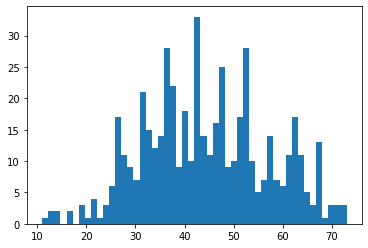

In [48]:
import matplotlib.pyplot as plt
plt.hist(n_frames, bins=50)

In [ ]:
# pseudo code
# load only the 10k easy videos. (Consider extracting the frames of those 10k videos and placing them in 
# ssv2/easy10)

# there are 10-70 frames in each video.
# for videomae, ds_rate=2 might be good. starting from the middle
# 1- it's somewhat important to cover most of the duration
# 2- it's also important to cover temporal precision. 
# 2 is more important

# collect all_frames
# try selecting with the suggested ds_rate, starting from the suggested point.
# if not enough, try starting from the beginning
# if still not enough, gradually reduce ds_rate.
# if not enough frames for ds_rate=1, repeat the last frame.

# set ds_rate to 2.
# set the starting point to 1/4th frames. 

In [ ]:
toybox_root = args.vid_root
#     '/N/project/baby_vision_curriculum/benchmarks/toybox/vids/toybox/'
transform = transform_vid
frame_rate=args.frame_rate
sample_len=args.num_frames
dataset = ToyboxDataset(toybox_root, transform, 
                      frame_rate=frame_rate, sample_len=sample_len)